## Imports

In [1]:
from mtcnn import MTCNN
from tensorflow.keras.models import load_model
import os
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


Setting the detector which will detect the face in Image

In [2]:
detector = MTCNN()

Loading the model

In [3]:
model = load_model('Models/facenet_keras.h5')

In [9]:
# path where the face embedding will be saved of the registered user
face_print_registry_database = 'Registry_database/Face Print/' 


# path where the images will be stored temporarily if you are using webcam of your system.
# You can also save your target images in this folder if you are not using a webcam
# Customize the folder according to your system. 
temp_face_capture_path = 'C:/Tensorflow_GPU/temp_cap/'

In [3]:
def marker_function(features,image,x1,x2,y1,y2):
    
    """ This function just mark the face and its components with a green line """
    
    detected_faces = features
        
    mask_clr = 'lawngreen'
    mask_width = 3
    draw = ImageDraw.Draw(image)
    draw.rectangle(((x1,y1), (x2,y2)), outline=mask_clr,width=mask_width)


    leye = detected_faces['keypoints']['left_eye']
    reye = detected_faces['keypoints']['right_eye']
    nose = detected_faces['keypoints']['nose']
    lmouth = detected_faces['keypoints']['mouth_left']
    rmouth = detected_faces['keypoints']['mouth_right']

    # left upper corner to left eye 
    draw.line((x1,y1)+leye, fill=mask_clr, width=mask_width)
    # right bottom corner to right eye
    draw.line((x2,y2)+reye, fill=mask_clr, width=mask_width)
    # left bottom corner to left mouth
    draw.line((x1,y2)+lmouth, fill=mask_clr, width=mask_width)
    # right bottom corner to right  mouth
    draw.line((x2,y2)+rmouth, fill=mask_clr, width=mask_width)
    # right upper corner to right mouth
    draw.line((x2,y1)+reye, fill=mask_clr, width=mask_width)
    # left bottom corner to left eye
    draw.line((x1,y2)+leye, fill=mask_clr, width=mask_width)
    # left upper corner to left mouth
    draw.line((x1,y1)+lmouth, fill=mask_clr, width=mask_width)
    # right uupper corner to right mouth
    draw.line((x2,y1)+rmouth, fill=mask_clr, width=mask_width)
    # right upper corner to left eye
    draw.line((x2,y1)+leye, fill=mask_clr, width=mask_width)
    # left upeer corner to right eye
    draw.line((x1,y1)+reye, fill=mask_clr, width=mask_width)
    # left bottom corner to right mouth
    draw.line((x1,y2)+rmouth, fill=mask_clr, width=mask_width)
    # right bottom corner to left mouth
    draw.line((x2,y2)+lmouth, fill=mask_clr, width=mask_width)
    # right middle divisor to right eye and mouth
    draw.line((x2,(y1+y2)//2)+reye, fill=mask_clr, width=mask_width)
    draw.line((x2,(y1+y2)//2)+rmouth, fill=mask_clr, width=mask_width)
    # left middle divisor to left mouth and eye 
    draw.line((x1,(y1+y2)//2)+leye, fill=mask_clr, width=mask_width)
    draw.line((x1,(y1+y2)//2)+lmouth, fill=mask_clr, width=mask_width)


    # top middle diviro to bot eyes
    draw.line(((x1+x2)//2,y1)+reye, fill=mask_clr, width=mask_width)
    draw.line(((x1+x2)//2,y1)+leye, fill=mask_clr, width=mask_width)
    # bottom middle divisor for bot mouths
    draw.line(((x1+x2)//2,y2)+rmouth, fill=mask_clr, width=mask_width)
    draw.line(((x1+x2)//2,y2)+lmouth, fill=mask_clr, width=mask_width)
    # middle star symbol
    draw.line(((x1+x2)//2,y1)+nose, fill=mask_clr, width=mask_width)
    draw.line(nose+(x2,y2), fill=mask_clr, width=mask_width)
    draw.line(nose+(x1,y2), fill=mask_clr, width=mask_width)



    draw.line(leye+reye,fill=mask_clr, width=mask_width)

    draw.line(leye+nose,fill=mask_clr, width=mask_width)

    draw.line(reye+nose, fill=mask_clr, width=mask_width)



    draw.line(nose+lmouth, fill=mask_clr, width=mask_width)

    draw.line(nose+rmouth, fill=mask_clr, width=mask_width)

    draw.line(lmouth+rmouth, fill=mask_clr, width=mask_width)


    eye_diffrence = reye[0]-leye[0]
#         print(eye_diffrence)

    image.save('marked.jpeg', "JPEG")

In [4]:
def get_face(path,resize_scale=(160,160)):
    
    """ 
    This function is used to extract the face of 160x160 from the given image 
    
    Input : image directory path as input
    Returns : A tuple containing list of faces found, the original image.
    
    """
    
    
    face_list=list()
    
    image = Image.open(path)
    image = image.convert('RGB')
        
    pixels = np.asarray(image)
#     print(pixels.shape)

    faces_detected = detector.detect_faces(pixels)

    for detected_faces in faces_detected:
        x1, y1, width, height = detected_faces['box']
        components = detected_faces
        x1,y1 = abs(x1),abs(y1)

        x2, y2 = x1+width, y1+height

        final_face = pixels[y1:y2,x1:x2]
        
#         marker_function(detected_faces,image,x1,x2,y1,y2)
        marker_function(detected_faces,image,x1,x2,y1,y2)

        
        pic = Image.fromarray(final_face)        
        pic = pic.resize(resize_scale)
        
        face_array = np.asarray(pic)
#         print(f'Extracted : {face_array.shape}')
        
        face_list.append(face_array)
    plt.imshow(image)
    plt.show()
    
    return face_list,image

In [5]:
def get_face_embeddings(face_pixels):
    
    """ This function takes faces extracted by get_face() and return a vector of 128 numbers known as Face Embeddings """
    
    face_pixels = face_pixels.astype('float32')
    
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std

    samples = np.expand_dims(face_pixels, axis=0)
    yhat = model.predict(samples)
    return yhat[0]

In [6]:
def capture_frame():
    
    """ Used to capture image from web cam """
    
    file_name = 'tempCapture'
    camera = cv2.VideoCapture(0)
    
    for i in range(2):
        ret, frame = camera.read()
        if ret:
            cv2.imwrite(f'C:/Tensorflow_GPU/temp_cap/{file_name}_{i}.png',frame)
        else:
            return 0
    camera.release()


In [7]:
def register_face(user_name):
    
    """ Saves the face embeddings into directory for comparision """
    
    registry_raw_img = os.listdir(temp_face_capture_path)[0]
    pixels_extracted, pixels_img = get_face(temp_face_capture_path+registry_raw_img) 
    if pixels_extracted:
        features_extracted = get_face_embeddings(pixels_extracted[0])
        if len(features_extracted):
            np.savez_compressed(f'{face_print_registry_database}{user_name}.npz',features_extracted)
        else:
            return 500 # Cannot extract the features
    else:
        return 404 # face not found
    
    

In [8]:
def load_saved_user():
    
    """ Loads the saved faces from directory """
    
    saved_faces = []
    saved_faces_names = []
    
    embeddings_list = os.listdir(face_print_registry_database)
    if embeddings_list:
        for saved_compressed in embeddings_list:
            loaded_embeddings = np.load(face_print_registry_database+saved_compressed)['arr_0']
            saved_faces.append(loaded_embeddings)
            saved_faces_names.append(saved_compressed.split('.')[0])

        return saved_faces,saved_faces_names
    else:
        return 0,0,

In [11]:
feature_threshold = 10 # The threshold used to estimate the similarity 

def verify(saved_embeddings,saved_username):
    
    '''
    Main function
    
    Work : 
        Extract the face embeddings of the given face
        compare those embaddings with the saved ones.
    
    '''
    
    if saved_embeddings:

        for captured_faces in os.listdir('C:/Tensorflow_GPU/temp_cap/'):
            target_face, target_img = get_face('C:/Tensorflow_GPU/temp_cap/'+captured_faces)
            if target_face:
                for faces in target_face:
                    target_face_embeddings = get_face_embeddings(faces)
                    
                    for every_face, name in zip(saved_embeddings,saved_username):
#                         print(every_face.shape,target_face_embeddings.shape)
                        
                        dist = np.linalg.norm(every_face-target_face_embeddings) # matching the image

                        if dist<feature_threshold:
                            print(f'Face Recognised as : {name}, Authentication Successfull | Vector Distance: {dist} | PIC : {captured_faces}')
                            return 1
                        else:
                            print(f'Face Not Recognised... | Vector Distance: {dist} | PIC : {captured_faces}')

            else:
                print('No face detected in the input image...\nTry keping ur face in center and straight.')
                return 404 # no face detected
    else:
        return 501 # no previous registed user found


Registering user

In [52]:
# capture_frame()
register_face('')

In [12]:
saved_embeddings,saved_username= load_saved_user()

In [13]:
saved_username

['Nitin', 'Tzuyu']

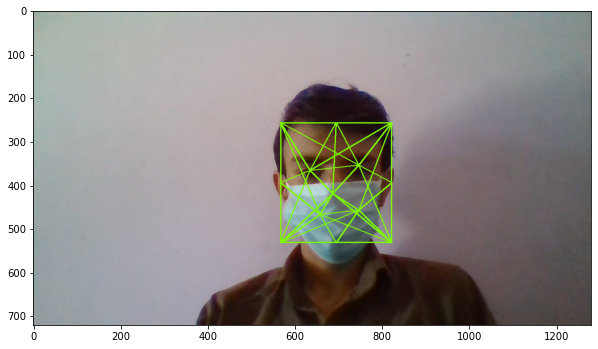

Face Not Recognised... | Vector Distance: 10.84415340423584 | PIC : WIN_20200713_11_09_13_Pro.jpg
Face Not Recognised... | Vector Distance: 16.782590866088867 | PIC : WIN_20200713_11_09_13_Pro.jpg


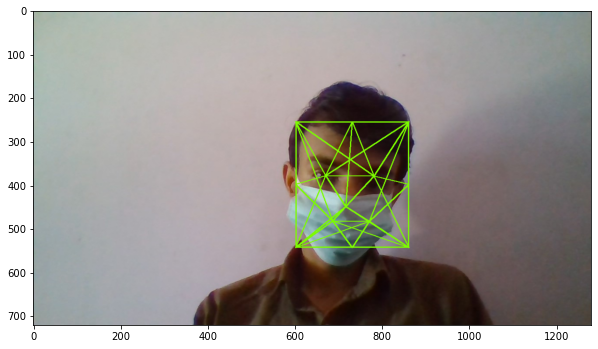

Face Not Recognised... | Vector Distance: 11.518343925476074 | PIC : WIN_20200713_11_09_20_Pro.jpg
Face Not Recognised... | Vector Distance: 16.190879821777344 | PIC : WIN_20200713_11_09_20_Pro.jpg


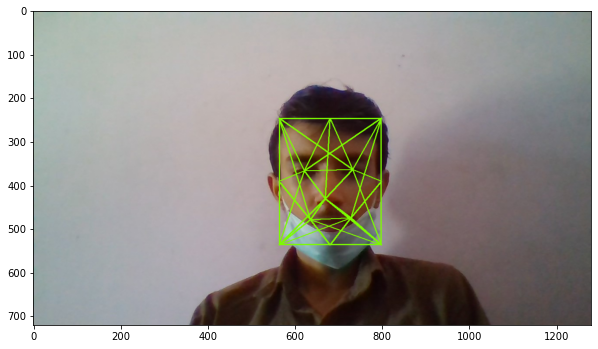

Face Recognised as : Nitin, Authentication Successfull | Vector Distance: 9.94815444946289 | PIC : WIN_20200713_11_11_21_Pro.jpg


1

In [14]:
# capture_frame()
verify(saved_embeddings,saved_username)